# Prior and posterior prediction

In [2]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf

INFO:bayesflow:Using backend 'jax'

Here we will revisit the basic binomial model:

And use it to generate important distributions.

### Prior and prior predictive distributions

The prior and prior predictive distributions are generated jointly by
the simulator.

In [8]:
def prior():
    return dict(theta=np.random.beta(a=1, b=1))

def likelihood(theta):
    return dict(k=np.random.binomial(n=15, p=theta))

simulator=bf.make_simulator([prior, likelihood])

In [50]:
samples=simulator.sample(5000)
prior=samples["theta"]
prior_predictives=samples["k"]

### Posterior distribution

To obtain the posterior distribution, we need to define a posterior
approximator and train it.

In [10]:
adapter = (
    bf.Adapter()
    .constrain("theta", lower=0, upper=1)
    .rename("theta", "inference_variables")
    .rename("k", "inference_conditions")
)

In [11]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow()
)

In [ ]:
history=workflow.fit_online(epochs=20, batch_size=512)

Once trained, we can apply it to obtain the posterior for a specific
data, e.g., $k=1$.

In [51]:
inference_data = dict(k=np.array([[1]]))
posterior=workflow.sample(num_samples=5000, conditions=inference_data)
posterior=posterior["theta"][0,:,0]

### Posterior predictive distribution

Can be generated from the simulator, using the posterior distribution of
the parameters.

In [52]:
posterior_predictives=simulator.sample(5000, theta=posterior)["k"]

Now we can also plot the distributions: First we plot the prior and
posterior distributions of the parameter, and then the prior and
posterior predictive distributions.

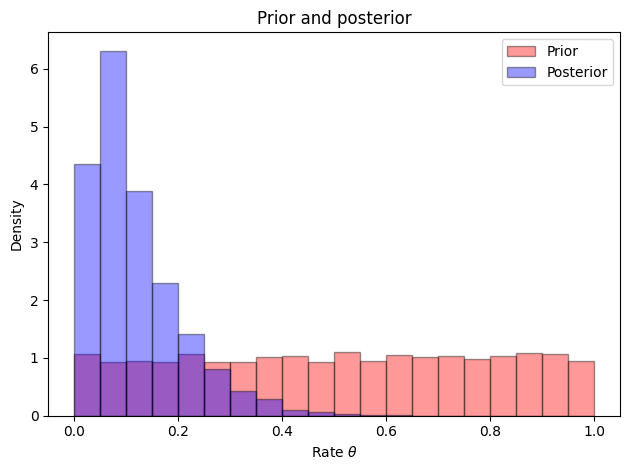

In [53]:
plt.hist(prior, 
         label="Prior", alpha=0.4,
         density=True, color="r", edgecolor="black", bins=np.arange(0, 1.05, 0.05))
plt.hist(posterior, 
         label="Posterior", alpha=0.4,
         density=True, color="b", edgecolor="black", bins=np.arange(0, 1.05, 0.05))
plt.legend()
plt.title("Prior and posterior")
plt.xlabel("Rate $\\theta$")
plt.ylabel("Density")
plt.tight_layout()

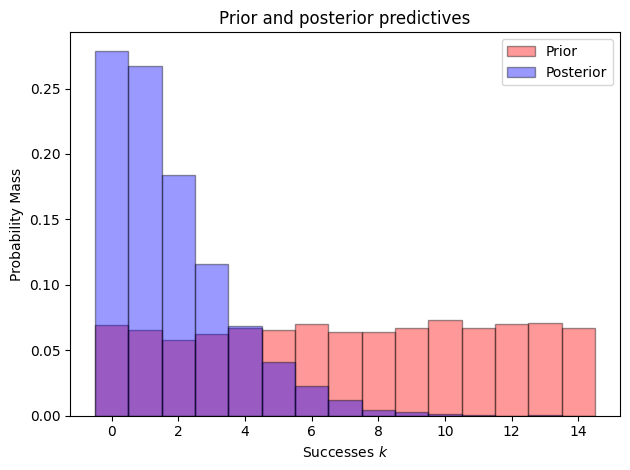

In [60]:
plt.hist(prior_predictives, 
         label="Prior", alpha=0.4,
         density=True, color="r", edgecolor="black", bins=np.arange(-0.5, 15.5))
plt.hist(posterior_predictives, 
         label="Posterior", alpha=0.4,
         density=True, color="b", edgecolor="black", bins=np.arange(-0.5, 15.5))
plt.legend()
plt.title("Prior and posterior predictives")
plt.xlabel("Successes $k$")
plt.ylabel("Probability Mass")
plt.tight_layout()